In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import plotnine as pn
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

Here I load all relevant data for this task:

In [13]:
base_path = Path().resolve() / "data"

In [15]:
web_visits_df = pd.read_csv(Path(base_path / 'web_visits.csv'))
app_usage_df = pd.read_csv(Path(base_path / 'app_usage.csv'))
claims_df = pd.read_csv(Path(base_path / 'claims.csv'))
churn_labels_df = pd.read_csv(Path(base_path / 'churn_labels.csv'))

### Feature engeniring

since I think there is a correlation between app or web visits frequency to churn I first want to calculate frequency per day per id from the data I have. since i assume there is no difference between app and web usage (or since i can cheack it later on) I'm going to union information from web_visits_df & app_usage_df:

In [16]:
web_app_usage_df = pd.concat([web_visits_df[['member_id','timestamp']], app_usage_df[['member_id','timestamp']]], ignore_index=True)
web_app_usage_df["timestamp"] = pd.to_datetime(web_app_usage_df["timestamp"], errors="coerce")
web_app_usage_df

,member_id,timestamp
0,1,2025-07-02 22:38:22
1,1,2025-07-02 11:30:47
2,1,2025-07-14 00:38:39
3,2,2025-07-07 02:56:06
4,2,2025-07-02 15:53:38
...,...,...
357124,10000,2025-07-01 11:05:24
357125,10000,2025-07-09 08:43:18
357126,10000,2025-07-05 11:25:41
357127,10000,2025-07-04 19:08:59


now I calculate visits frequency per day per id, by calculating the time_range (max - min) and divading the visit count with this range

In [17]:
def calculate_freq(df):
    # Convert 'timestamp' column to datetime format:
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    
    # Group by 'member_id' and aggregate
    result = df.groupby("member_id").agg(
        timestamp_count=("timestamp", "count"),
        first_time=("timestamp", "min"),
        last_time=("timestamp", "max")
    )
    
    # Calculate the range of time (difference)
    result["time_range"] = result["last_time"] - result["first_time"]
    
    # Convert timedelta to days
    result["time_range_days"] = result["time_range"].dt.total_seconds() / (24 * 60 * 60)
    
    # calculate usage frequency (timestamps count per day)
    result["frequency_per_day"] = result["timestamp_count"] / result["time_range_days"]
    
    result.reset_index(inplace=True)
    
    return result

result = calculate_freq(web_app_usage_df[['member_id','timestamp']])
result

,member_id,timestamp_count,first_time,last_time,time_range,time_range_days,frequency_per_day
0,1,9,2025-07-02 11:30:47,2025-07-14 15:28:58,12 days 03:58:11,12.165405,0.739803
1,2,19,2025-07-01 00:37:35,2025-07-14 01:37:25,13 days 00:59:50,13.041551,1.456882
2,3,61,2025-07-01 07:12:25,2025-07-14 21:10:29,13 days 13:58:04,13.581991,4.491241
3,4,25,2025-07-01 10:39:28,2025-07-13 22:17:45,12 days 11:38:17,12.484919,2.002416
4,5,21,2025-07-01 08:40:53,2025-07-13 22:48:22,12 days 14:07:29,12.588530,1.668185
...,...,...,...,...,...,...,...
9995,9996,26,2025-07-01 01:48:31,2025-07-14 03:01:11,13 days 01:12:40,13.050463,1.992266
9996,9997,19,2025-07-01 04:00:51,2025-07-13 21:30:48,12 days 17:29:57,12.729132,1.492639
9997,9998,20,2025-07-01 04:40:55,2025-07-13 12:43:46,12 days 08:02:51,12.335313,1.621361
9998,9999,43,2025-07-01 01:30:35,2025-07-14 18:57:29,13 days 17:26:54,13.727014,3.132509


Here I show that my calculation didn't create some invalid values (for example infinity):

In [18]:
result[np.isinf(result["frequency_per_day"])]

,member_id,timestamp_count,first_time,last_time,time_range,time_range_days,frequency_per_day


In [19]:
result["time_range_days"].describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

count    10000.000000
mean        13.041309
std          0.872920
min          3.169282
10%         11.945420
20%         12.556775
30%         12.890906
40%         13.127597
50%         13.298796
60%         13.445079
70%         13.570465
80%         13.682377
90%         13.800571
max         13.998993
Name: time_range_days, dtype: float64

The above describe method shows that we are looking at data of 10,000 members and that lass then 10%  of the members has 
time_range_days < 12 days and most of them have time_range_days ~ 12 - 14 days, so I asume that this data was collected in pre_defined time window of 2 weeks. it make sense to me that the thought was to experimentaly look at limted time-window 
Next to chanks of code support this assumption since it shows that most first_time (minmum of timestamp visits) are at 2025-07-01
and most last_time (maximum of timestamp visits) are at 2025-07-14

In [20]:
pd.to_datetime(result['first_time']).dt.floor('D').describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

count                         10000
mean     2025-07-01 04:01:46.560000
min             2025-07-01 00:00:00
10%             2025-07-01 00:00:00
20%             2025-07-01 00:00:00
30%             2025-07-01 00:00:00
40%             2025-07-01 00:00:00
50%             2025-07-01 00:00:00
60%             2025-07-01 00:00:00
70%             2025-07-01 00:00:00
80%             2025-07-01 00:00:00
90%             2025-07-02 00:00:00
max             2025-07-08 00:00:00
Name: first_time, dtype: object

In [21]:
pd.to_datetime(result['last_time']).dt.floor('D').describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

count                         10000
mean     2025-07-13 20:06:08.640000
min             2025-07-07 00:00:00
10%             2025-07-13 00:00:00
20%             2025-07-14 00:00:00
30%             2025-07-14 00:00:00
40%             2025-07-14 00:00:00
50%             2025-07-14 00:00:00
60%             2025-07-14 00:00:00
70%             2025-07-14 00:00:00
80%             2025-07-14 00:00:00
90%             2025-07-14 00:00:00
max             2025-07-14 00:00:00
Name: last_time, dtype: object

Now I want to graphically check whether there is a difference in members behavior with respect to churn.
First let us merge the churn dataframe into result dataframe by ID

In [22]:
result = pd.merge(result, churn_labels_df, how='left', on='member_id')

In [11]:
result

,member_id,timestamp_count,first_time,last_time,time_range,time_range_days,frequency_per_day,signup_date,churn,outreach
0,1,9,2025-07-02 11:30:47,2025-07-14 15:28:58,12 days 03:58:11,12.165405,0.739803,2024-04-12,0,0
1,2,19,2025-07-01 00:37:35,2025-07-14 01:37:25,13 days 00:59:50,13.041551,1.456882,2025-03-11,0,0
2,3,61,2025-07-01 07:12:25,2025-07-14 21:10:29,13 days 13:58:04,13.581991,4.491241,2024-09-27,0,0
3,4,25,2025-07-01 10:39:28,2025-07-13 22:17:45,12 days 11:38:17,12.484919,2.002416,2024-04-16,1,0
4,5,21,2025-07-01 08:40:53,2025-07-13 22:48:22,12 days 14:07:29,12.588530,1.668185,2024-03-12,0,1
...,...,...,...,...,...,...,...,...,...,...
9995,9996,26,2025-07-01 01:48:31,2025-07-14 03:01:11,13 days 01:12:40,13.050463,1.992266,2024-09-02,0,0
9996,9997,19,2025-07-01 04:00:51,2025-07-13 21:30:48,12 days 17:29:57,12.729132,1.492639,2024-02-07,0,0
9997,9998,20,2025-07-01 04:40:55,2025-07-13 12:43:46,12 days 08:02:51,12.335313,1.621361,2024-09-01,0,0
9998,9999,43,2025-07-01 01:30:35,2025-07-14 18:57:29,13 days 17:26:54,13.727014,3.132509,2024-01-21,0,0


In [23]:
# create categorial variable from churn (ideal for visualization purpose)
result['churn_category'] = result['churn'].astype('category')

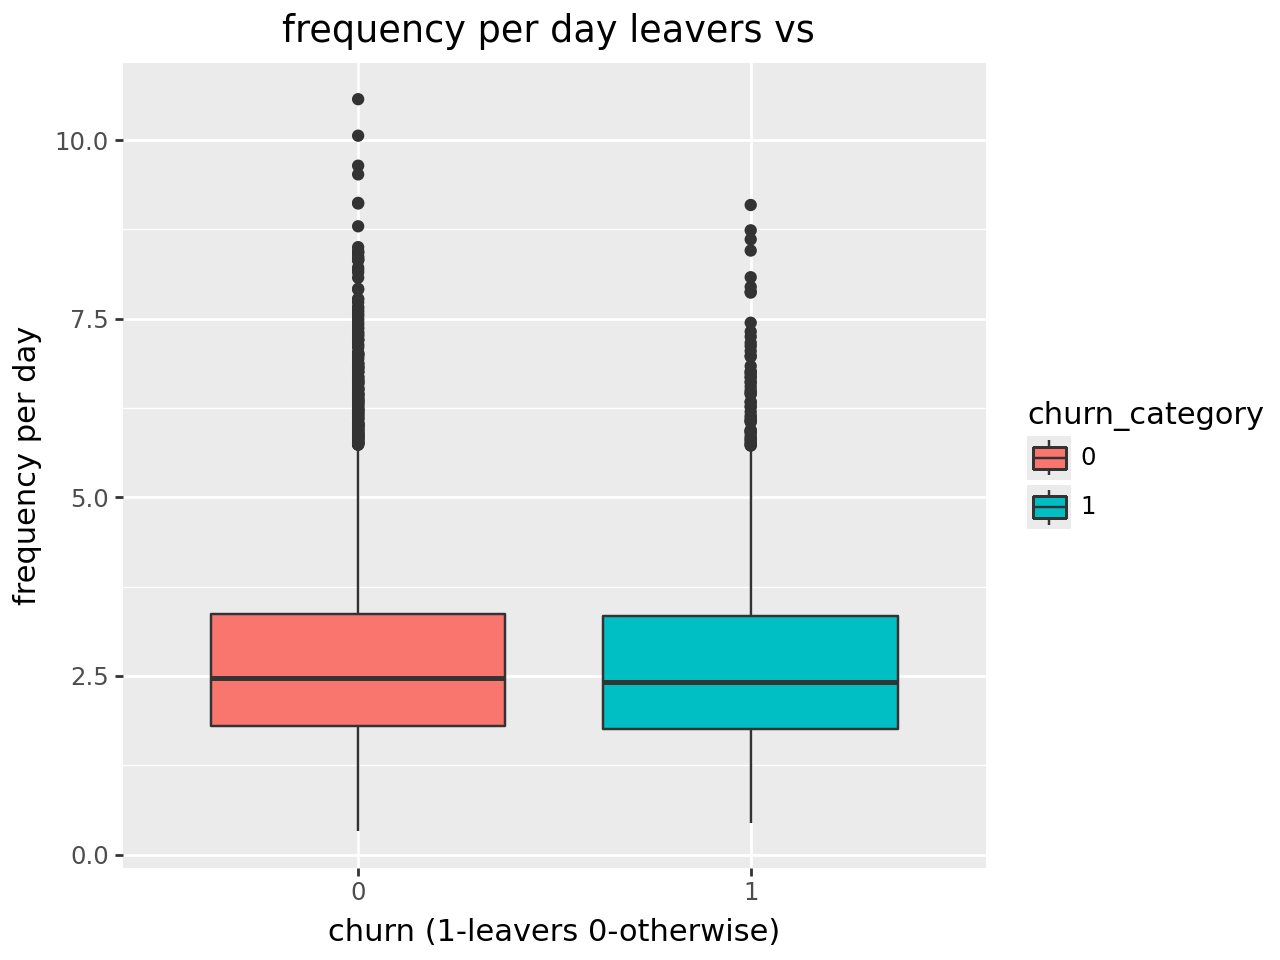

In [24]:
pn.ggplot(result, pn.aes(x='churn_category' ,y='frequency_per_day', fill='churn_category')) + \
    pn.geom_boxplot() + \
            pn.xlab('churn (1-leavers 0-otherwise)') + \
                pn.ylab('frequency per day') + \
                    pn.ggtitle('frequency per day leavers vs ') 

I checked visually the difference between users usage with concerne to churn(with a boxplot comparison above), it dosen't look like there is a significant diffrance. 
somtimes it is not easy to see with boxplot so lets try to compare the frequency_per_day between churn_category groups ("0" & "1"):

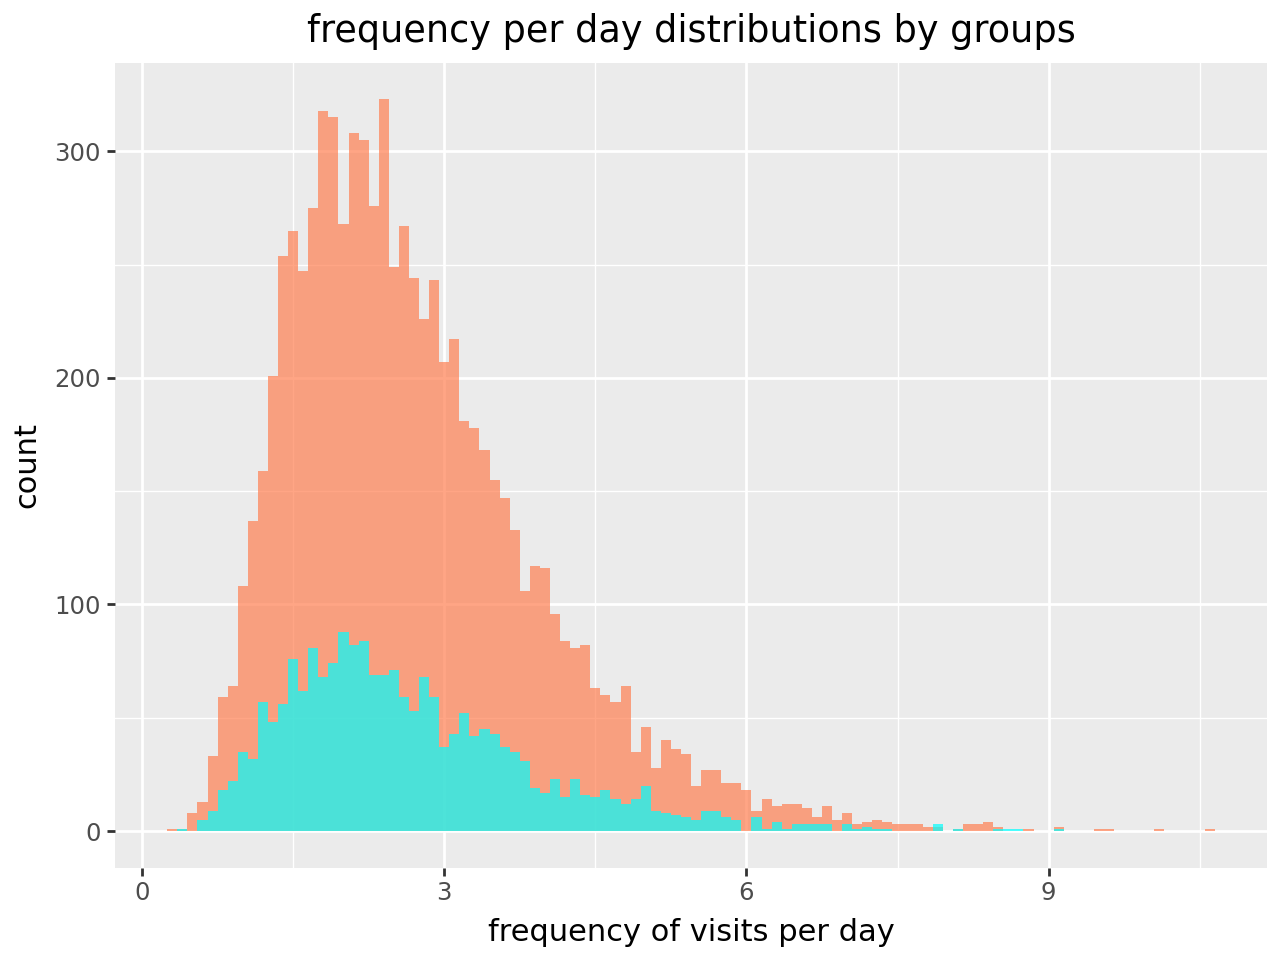

In [25]:
pn.ggplot() + \
    pn.geom_histogram(result.loc[result['churn_category']==0], pn.aes(x='frequency_per_day'), binwidth=0.1, fill = 'coral', alpha=0.7) + \
        pn.geom_histogram(result.loc[result['churn_category']==1], pn.aes(x='frequency_per_day'), binwidth=0.1, fill = 'aqua', alpha=0.7) + \
            pn.ggtitle('frequency per day distributions by groups') + \
                pn.xlab('frequency of visits per day')


The above frequency_per_day distributions comparison dosen't show distribution difference between churn_category groups ("0" & "1")

I could also cheack it ststisticaly, but the issue with such cheack that with large n it almost always shows significant diffrance.

Perhaps calculating frequency_per_day using a 2-week window didn’t generate meaningful insights, as the window might be too narrow. Let’s try to learn what insights we can gain from the variable signup_date:

First, I created a new variable from signup_date representing the number of days that passed between the signup date and the member’s last visit to the app or website. I called this variable days_since_signup.

In [26]:
result["signup_date"] = pd.to_datetime(result["signup_date"], format="%Y-%m-%d")
result["days_since_signup"] = (result["last_time"] - result["signup_date"]).dt.days
result

,member_id,timestamp_count,first_time,last_time,time_range,time_range_days,frequency_per_day,signup_date,churn,outreach,churn_category,days_since_signup
0,1,9,2025-07-02 11:30:47,2025-07-14 15:28:58,12 days 03:58:11,12.165405,0.739803,2024-04-12,0,0,0,458
1,2,19,2025-07-01 00:37:35,2025-07-14 01:37:25,13 days 00:59:50,13.041551,1.456882,2025-03-11,0,0,0,125
2,3,61,2025-07-01 07:12:25,2025-07-14 21:10:29,13 days 13:58:04,13.581991,4.491241,2024-09-27,0,0,0,290
3,4,25,2025-07-01 10:39:28,2025-07-13 22:17:45,12 days 11:38:17,12.484919,2.002416,2024-04-16,1,0,1,453
4,5,21,2025-07-01 08:40:53,2025-07-13 22:48:22,12 days 14:07:29,12.588530,1.668185,2024-03-12,0,1,0,488
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,26,2025-07-01 01:48:31,2025-07-14 03:01:11,13 days 01:12:40,13.050463,1.992266,2024-09-02,0,0,0,315
9996,9997,19,2025-07-01 04:00:51,2025-07-13 21:30:48,12 days 17:29:57,12.729132,1.492639,2024-02-07,0,0,0,522
9997,9998,20,2025-07-01 04:40:55,2025-07-13 12:43:46,12 days 08:02:51,12.335313,1.621361,2024-09-01,0,0,0,315
9998,9999,43,2025-07-01 01:30:35,2025-07-14 18:57:29,13 days 17:26:54,13.727014,3.132509,2024-01-21,0,0,0,540


days_since_signup variable clearly shows a difference between the groups:

In [27]:
result.groupby("churn_category", observed=False)["days_since_signup"].describe()

,count,mean,std,min,25%,50%,75%,max
churn_category,,,,,,,,
0,7979.0,312.751974,147.382195,43.0,186.0,318.0,442.0,560.0
1,2021.0,261.739238,149.974905,42.0,127.0,243.0,388.0,560.0


lets convert days_since_signup to categorical variable (days_since_signup_cut, for visualization purpose) and show the difference between churn groups with respect to days_since_signup 

In [28]:
result["days_since_signup_cut"] = pd.cut(result["days_since_signup"],
                                bins=[0, 100, 150, 200, 250, 300, 350, 400, 450, 500, 560],
                                    labels=[100, 150,200, 250, 300, 350, 400, 450, 500, 560])

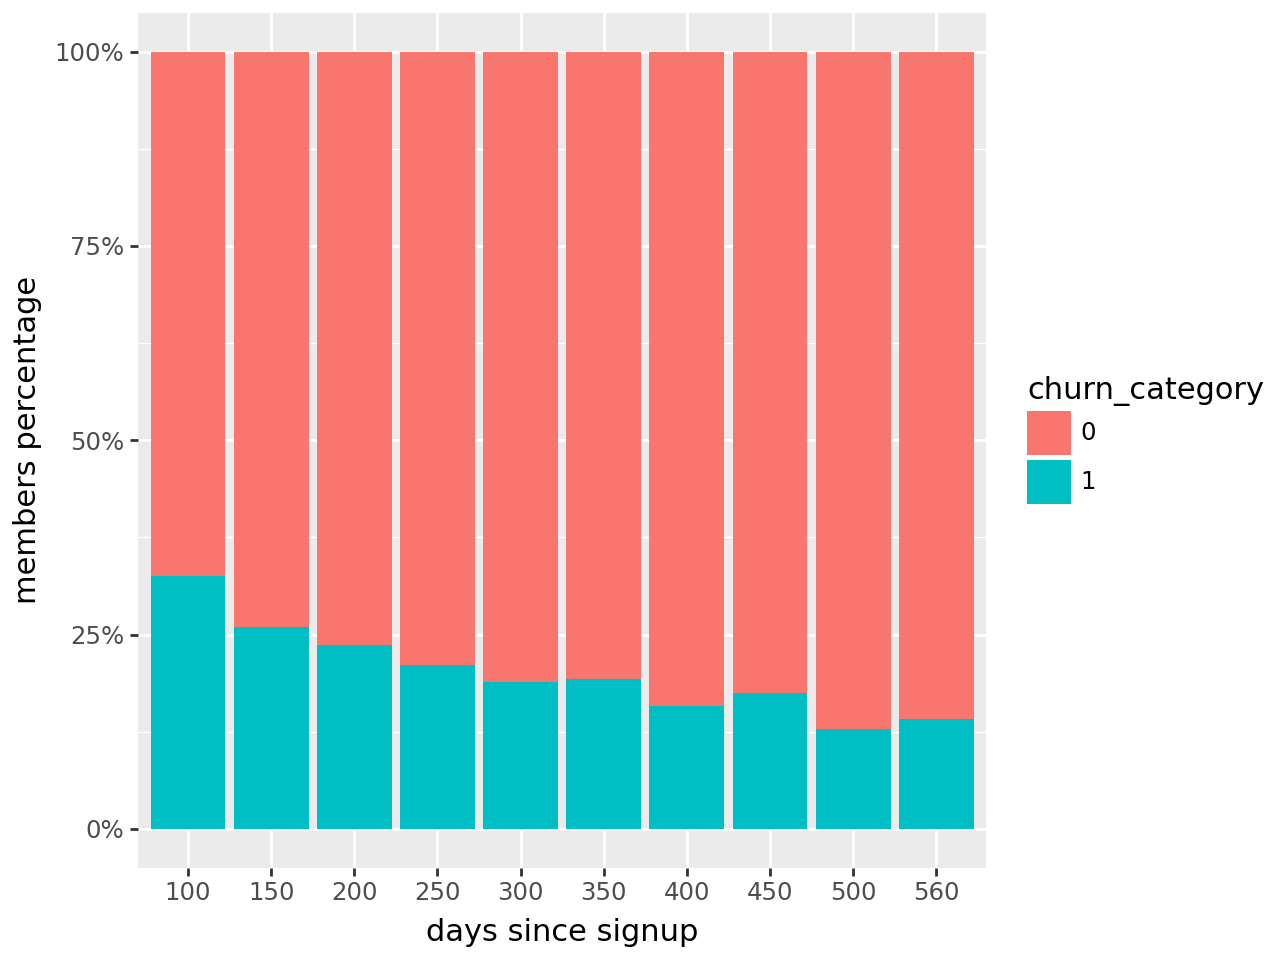

In [29]:
result['days_since_signup_cut'] = result['days_since_signup_cut'].astype('category')

pn.ggplot(result, pn.aes(x='days_since_signup_cut', fill = 'churn_category')) + \
    pn.geom_bar(position = "fill")  + \
        pn.scale_y_continuous(labels=lambda l: ["{:.0f}%".format(v*100) for v in l]) + \
                pn.xlab('days since signup') + \
                    pn.ylab('members percentage')
       

days_since_signup variable clearly influences the probability of churn(1-churn, 0-otherwise), which changes depending on its value. 
This finding made me think that survival analysis could be used here to understand which members should be prioritized for outreach in order to reduce member churn.

# Survival analysis 

Survival analysis is widely used to assess patient survival for specific diseases in medicine, to estimate the time until an insurance-related event in the insurance industry, and to evaluate the time until customer churn in retention analysis. 
To run my survival analysis I used: https://lifelines.readthedocs.io/en/latest/Quickstart.html
All relevent explanations on this analysis are in the power point presentation survival analisis I added to this repo.
for more info I reccomend this video in which I used to explain the analysis to non-technical stakeholders:
https://www.youtube.com/watch?v=EDKriUBcy2M 

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-colorblind")
sns.set_style("darkgrid")
sns.set_context("notebook")

In [31]:
%matplotlib inline

In [32]:
from lifelines import KaplanMeierFitter

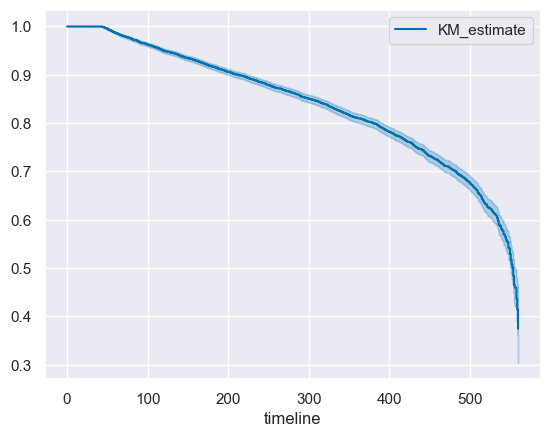

In [33]:
kmf_all = KaplanMeierFitter()
ax = kmf_all.fit(result['days_since_signup'], event_observed=result['churn']).plot_survival_function()


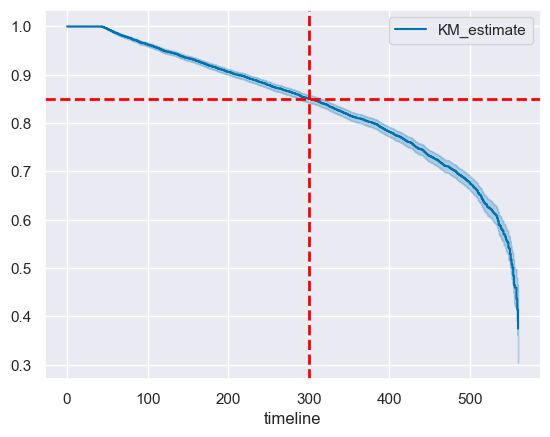

In [34]:
kmf_all = KaplanMeierFitter()
ax = kmf_all.fit(result['days_since_signup'], event_observed=result['churn']).plot_survival_function()

# Define some x-value
x_val = 300

# Find corresponding y-value (survival probability)
y_val = kmf_all.predict(x_val)

# Add vertical and horizontal lines
ax.axvline(x=x_val, color='red', linestyle='--', linewidth=2)
ax.axhline(y=y_val, color='red', linestyle='--', linewidth=2)

Using the Kaplan–Meier estimator we can fit our Xi’s to predict the probability of a member to stay engaged at a certain time point and use this probability to rank the top n members for outreach.
The lower the probability is the higher rank the member gets.

In [35]:
# Predict survival probabilities
survival_probs = kmf_all.predict(result["days_since_signup"])

# Add as a new column to the result DataFrame
result["predicted_survival_probs"] = survival_probs.reset_index(drop=True)
result[['member_id','days_since_signup','predicted_survival_probs']]

,member_id,days_since_signup,predicted_survival_probs
0,1,458,0.724856
1,2,125,0.947690
2,3,290,0.855495
3,4,453,0.729516
4,5,488,0.692315
...,...,...,...
9995,9996,315,0.841893
9996,9997,522,0.625789
9997,9998,315,0.841893
9998,9999,540,0.578684


In [36]:
# Sort descending
outreach_df = result[['member_id','days_since_signup','predicted_survival_probs']].sort_values(by='predicted_survival_probs', ascending=True)
outreach_df

,member_id,days_since_signup,predicted_survival_probs
4629,4630,560,0.374704
5421,5422,560,0.374704
815,816,560,0.374704
2913,2914,560,0.374704
9911,9912,560,0.374704
...,...,...,...
8504,8505,43,0.999700
8828,8829,43,0.999700
2443,2444,43,0.999700
5315,5316,43,0.999700


Here I save the dataset as CSV as required in the task document:

In [75]:
outreach_df.to_csv(Path(base_path / 'output.csv'), index=False)

This part does the same as above, but also prints the values used to built the curve at every time step under the curve as a table bellow the plot - in which, under each relevant time point (on X axis) we can see:
"At risk" = number of subjects at risk immediately before the time point (X) 
            Being "at risk" means that the subject has not had an event before time t, and is not censored before or at time t.
censored = indicated by the variable "churn". 0 = no event (censored), 1 = event (churn event in our case) 

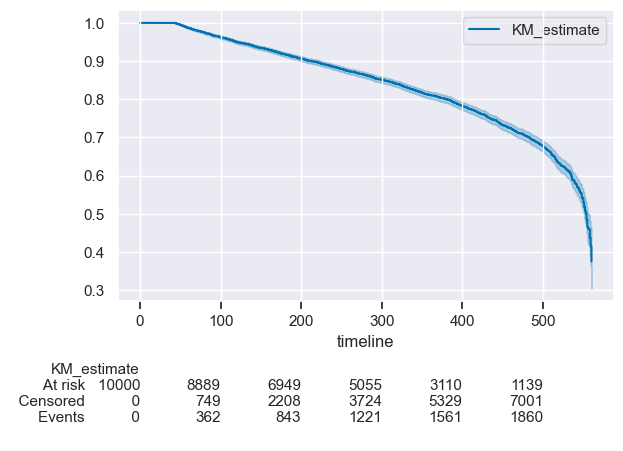

In [37]:
kmf_all = KaplanMeierFitter()
ax = kmf_all.fit(result['days_since_signup'], event_observed=result['churn']).plot_survival_function()

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf_all, ax=ax)
plt.tight_layout()


### Bonus Does outreach affect the member churn rate

Please see the relevant explainetuons for this bonus part at the bonus pages in in the power point presentation:

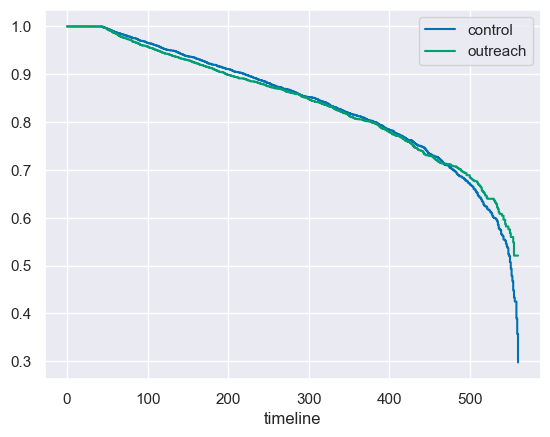

In [39]:
groups = result['outreach']
ix = (groups == 1)

kmf = KaplanMeierFitter()

kmf.fit(result['days_since_signup'][~ix], event_observed=result['churn'][~ix], label='control')
ax = kmf.plot_survival_function(ci_show=False)

kmf.fit(result['days_since_signup'][ix], result['churn'][ix], label='outreach')
ax = kmf.plot_survival_function(ax=ax, ci_show=False)

(0.4, 0.9)

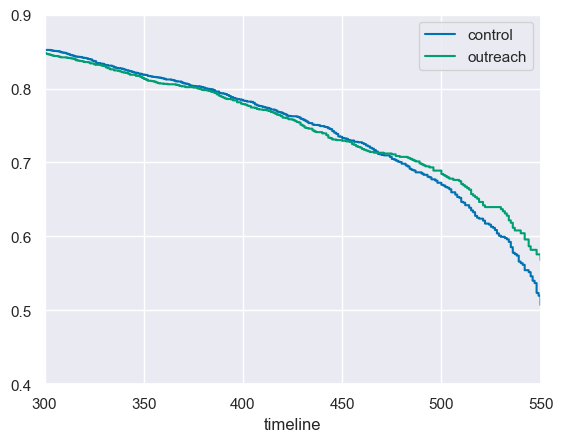

In [40]:
kmf.fit(result['days_since_signup'][~ix], event_observed=result['churn'][~ix], label='control')
ax = kmf.plot_survival_function(ci_show=False)

kmf.fit(result['days_since_signup'][ix], result['churn'][ix], label='outreach')
ax = kmf.plot_survival_function(ax=ax, ci_show=False)
plt.xlim(300, 550)
plt.ylim(0.4, 0.9)

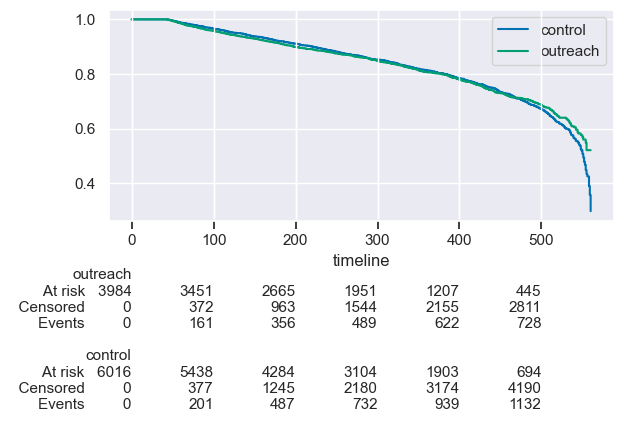

In [41]:
groups = result['outreach']
ix = (groups == 1)

kmf_control = KaplanMeierFitter()
ax = kmf_control.fit(result['days_since_signup'][~ix], event_observed=result['churn'][~ix], label='control').plot_survival_function(ci_show=False)


kmf_outreach = KaplanMeierFitter()
ax = kmf_outreach.fit(result['days_since_signup'][ix], result['churn'][ix], label='outreach').plot_survival_function(ax=ax, ci_show=False)


from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf_outreach, kmf_control, ax=ax)
plt.tight_layout()

## Discussion

in principle, there is room to expand the analysis in the following ways:

1. Additional variables that were not examined could be included to assess how they affect the churn rate.
For example, diagnoses (icd_code) could be added to evaluate their impact on member churn — it is possible that members with diabetes tend to use the service more than those with hypertension.
2. Extending the observation window to more than two weeks.
3. I would recommend a different approach to data extraction — to define a fixed time window in which all active members are collected, rather than relying solely on website or app logins. This way, we obtain a less biased estimate (based on cross-referencing the ID member_id from the files, I understood that the data was collected differently — that is, the recorded signup dates refer only to members who accessed the website or app within the specified time window.)

For a deep dive into all the theoretical math and statistics behind survival analysis:

https://en.wikipedia.org/wiki/Survival_analysis

https://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator